In [7]:
import ast
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sentence_transformers import datasets, evaluation, InputExample, losses, models, SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

c:\Users\Billy\miniforge3\envs\homedepot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the Data

In [3]:
def convert_to_dict(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return None  # Handle cases where the string is not a valid dictionary representation

def dict_to_string(my_dict):
    result_str = ""
    for key, value in my_dict.items():
        result_str += str(key) + ' ' + str(value) + ' '
    return result_str

In [4]:
df_prods = pd.read_csv('/kaggle/input/homedepot/df_prods.csv')

df_prods['product_attributes'] = df_prods['product_attributes'].apply(convert_to_dict)
df_prods['product_attributes_string'] = [dict_to_string(x) if x is not None else x for x in df_prods['product_attributes']]
df_prods['product_text_string'] = df_prods['product_title'].fillna('') + ' ' + df_prods['product_description'].fillna('') + ' ' + df_prods['product_attributes_string'].fillna('') 

In [5]:
df_queries = pd.read_csv('/kaggle/input/homedepot/df_queries.csv')
prompt = 'Represent this sentence for searching relevant passages: '
df_queries['search_query'] = [prompt + str(x) for x in df_queries['search_term']]

df_relevance = pd.read_csv('/kaggle/input/homedepot/df_relevance.csv')

# Create the Embeddings

In [1]:
# Load the baseline model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = SentenceTransformer("Snowflake/snowflake-arctic-embed-m", trust_remote_code=True)

print(model)

In [2]:
query_embeddings = model.encode(df_queries['search_query'].tolist())
df_queries['base_query_embedding'] = [row for row in query_embeddings]

In [3]:
product_embeddings = model.encode(df_prods['product_text_string'].tolist())
df_prods['base_prod_embedding'] = [row for row in product_embeddings]

In [10]:
# Load the finetuned model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

ft_model = SentenceTransformer("/kaggle/input/homedepot_finetune/transformers/hd-fintune-testdata/1/finetuned", trust_remote_code=True)

print(ft_model)

Using cuda:0 device
SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)


In [4]:
query_embeddings = ft_model.encode(df_queries['search_query'].tolist())
df_queries['ft_query_embedding'] = [row for row in query_embeddings]

In [5]:
product_embeddings = ft_model.encode(df_prods['product_text_string'].tolist())
df_prods['ft_prod_embedding'] = [row for row in product_embeddings]

# Calculate Similarities

In [13]:
df_relevance = df_relevance.merge(df_prods[['product_uid', 'base_prod_embedding', 'ft_prod_embedding']],
                                  how = 'left', on = 'product_uid')
df_relevance = df_relevance.merge(df_queries[['query_id', 'base_query_embedding', 'ft_query_embedding']],
                                  how = 'left', on = 'query_id')

In [14]:
df_relevance['base_similarity'] = [cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))[0][0] for x,y in zip(df_relevance['base_query_embedding'],
                                                                                                              df_relevance['base_prod_embedding'])]
df_relevance['ft_similarity'] = [cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))[0][0] for x,y in zip(df_relevance['ft_query_embedding'],
                                                                                                            df_relevance['ft_prod_embedding'])]
df_relevance['similarity_diff'] = df_relevance['ft_similarity'] - df_relevance['base_similarity']

# Examine Effects

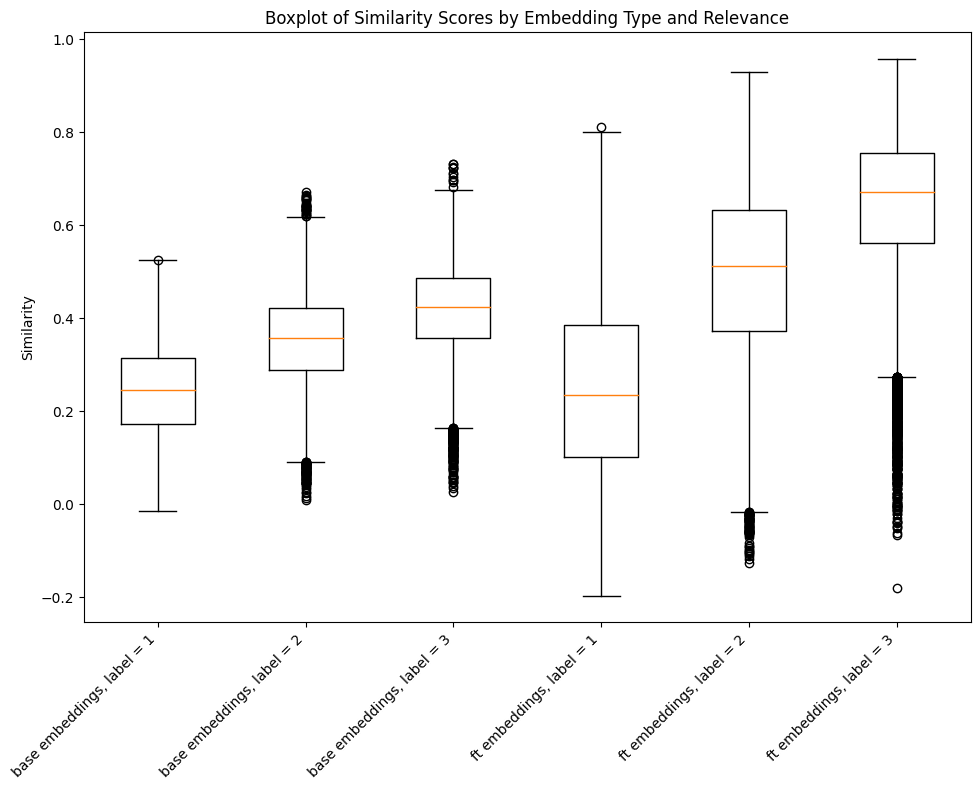

In [15]:
data = []
labels = []

for embedding_type in ['base', 'ft']:
    for relevance in [1,2,3]:
        tmp_values = df_relevance[df_relevance['relevance']==relevance][embedding_type + '_similarity'].values
        data.append(tmp_values)
        labels.append(embedding_type + ' embeddings, label = ' + str(relevance))
    
fig, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(data)


ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Similarity')
ax.set_title('Boxplot of Similarity Scores by Embedding Type and Relevance')

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

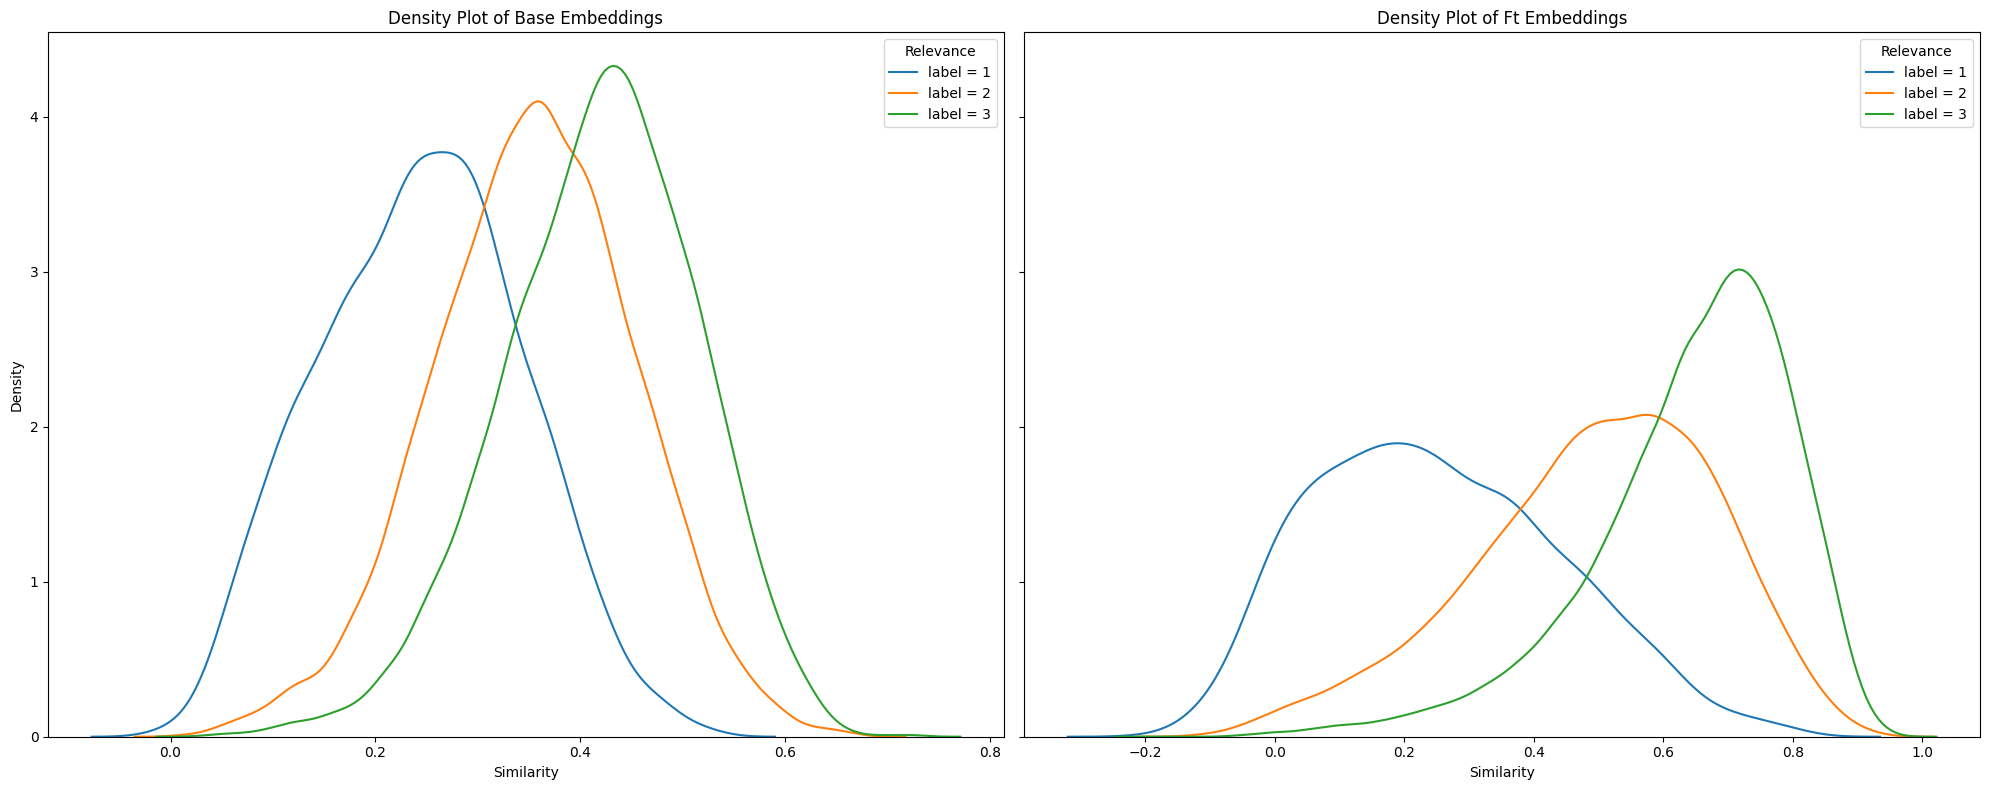

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

embedding_types = ['base', 'ft']

# Iterate over embedding types
for ax, embedding_type in zip(axes, embedding_types):
    for relevance in [1, 2, 3]:
        tmp_values = df_relevance[df_relevance['relevance'] == relevance][embedding_type + '_similarity'].values
        sns.kdeplot(tmp_values, ax=ax, label=f'label = {relevance}', fill=False)
    
    # Set labels and title for each subplot
    ax.set_xlabel('Similarity')
    ax.set_title(f'Density Plot of {embedding_type.capitalize()} Embeddings')
    ax.legend(title='Relevance')

# Set a common y-axis label
axes[0].set_ylabel('Density')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
summary_df = pd.DataFrame()

# Generate the description for each set of data and add to the summary DataFrame
for i, (values, label) in enumerate(zip(data, labels)):
    desc = pd.DataFrame(values).describe().transpose()
    desc['label'] = label
    summary_df = pd.concat([summary_df, desc], ignore_index=True)

summary_df.to_csv('/kaggle/working/summary_df.csv')
summary_df

,count,mean,std,min,25%,50%,75%,max,label
0,2115.0,0.244308,0.098306,-0.013320,0.172922,0.247002,0.313785,0.526347,"base embeddings, label = 1"
1,11765.0,0.354295,0.098911,0.010347,0.289238,0.356768,0.421315,0.671942,"base embeddings, label = 2"
2,19174.0,0.419073,0.095352,0.026245,0.357010,0.424748,0.485939,0.731508,"base embeddings, label = 3"
3,2115.0,0.252324,0.190257,-0.196073,0.101887,0.234911,0.384847,0.811392,"ft embeddings, label = 1"
4,11765.0,0.493689,0.188337,-0.126590,0.373647,0.511819,0.633850,0.930485,"ft embeddings, label = 2"
5,19174.0,0.643719,0.155577,-0.180241,0.562712,0.671258,0.754760,0.957232,"ft embeddings, label = 3"


In [18]:
# Positive relevance that moved closer
pos_closer = df_relevance[df_relevance['relevance']==3].sort_values('similarity_diff', ascending=False).head()
pos_closer = pos_closer.merge(df_queries[['search_term', 'query_id']], how = 'left', on ='query_id')
pos_closer = pos_closer.merge(df_prods[['product_text_string', 'product_uid']], how = 'left', on ='product_uid')
pos_closer.to_csv('/kaggle/working/pos_closer.csv')

pos_closer[['search_term', 'product_text_string', 'base_similarity', 'ft_similarity']]

,search_term,product_text_string,base_similarity,ft_similarity
0,vacume,RIDGID 14-gal. Professional Wet/Dry Vacuum Thi...,0.144208,0.748082
1,post sleeveee,RDI Crossover 6 in. x 6 in. x 54 in. Post Slee...,0.276639,0.864750
2,sheet metal,Crown Bolt 24 in. x 1/2 in. x 12 in. Plain Met...,0.261905,0.844295
3,black bench,Tradewinds Oasis 6 ft. Textured Black Bench wi...,0.337759,0.903013
4,vaccum for dw745,Dirt Devil Express V6 Bagless Wet/Dry Handheld...,0.209008,0.767965


In [19]:
pos_closer = pd.read_csv('processed_data/pos_closer.csv')
for index, row in pos_closer.iterrows():
    print(f"-------")
    print(f"Search Term: {row['search_term']}")
    print(f"Product: {row['product_text_string']}")
    print(f"Base Similarity: {str(round(row['base_similarity'],3))}")
    print(f"Fine-Tune Similarity: {str(round(row['ft_similarity'],3))}\n")

-------
Search Term: vacume
Product: RIDGID 14-gal. Professional Wet/Dry Vacuum This RIDGID 14-gal. High Performance Wet/Dry Vacuum is designed to deliver the powerful suction, large capacity and rugged construction in a more compact design than is offered in our largest cart type vacs. The vacuums 14-gal. drum size helps us achieve a more compact overall design but it still provides a big capacity capable of handling large job-site chores. The 6.0 peak HP motor delivers the high performance necessary to handle these chores. Other key features include; a 3-layer fine dust filter captures dry wall dust, accessories are stored on-board, casters provide 360 degree mobility. Add a top handle with a cord wrap, heavy duty 2-piece drum construction, a large drain and you've got a wet/dry vac that achieves the demands of Pros on the job site or in the shop.6 peak HP motor with noise-reduction technology offers powerful yet quiet performanceBlowing feature blows away sawdust and other debris20 

In [19]:
pos_further = df_relevance[df_relevance['relevance']==3].sort_values('similarity_diff', ascending=True).head()
pos_further = pos_further.merge(df_queries[['search_term', 'query_id']], how = 'left', on ='query_id')
pos_further = pos_further.merge(df_prods[['product_text_string', 'product_uid']], how = 'left', on ='product_uid')
pos_further.to_csv('/kaggle/working/pos_further.csv')

pos_further[['search_term', 'product_text_string', 'base_similarity', 'ft_similarity']]

,search_term,product_text_string,base_similarity,ft_similarity
0,everbilt sloted,Everbilt #8 x 1-1/2 in. Zinc-Plated Hex-Head S...,0.471475,0.141895
1,owt,OWT Ornamental Wood Ties 6 in. x 6 in. Laredo ...,0.325656,0.003995
2,GLACIER BAY BATHROOM VANITY,Glacier Bay Modular 30-1/2 in. W x 18-3/4 in. ...,0.615123,0.307893
3,unique home design,Unique Home Designs 3 in. White Projection Bra...,0.322623,0.015970
4,everbilt sloted,Everbilt #10 x 3/4 in. Zinc-Plated Hex-Head Sl...,0.466274,0.160345


In [20]:
pos_further = pd.read_csv('processed_data/pos_further.csv')
for index, row in pos_further.iterrows():
    print(f"-------")
    print(f"Search Term: {row['search_term']}")
    print(f"Product: {row['product_text_string']}")
    print(f"Base Similarity: {str(round(row['base_similarity'],3))}")
    print(f"Fine-Tune Similarity: {str(round(row['ft_similarity'],3))}\n")

-------
Search Term: everbilt sloted
Product: Everbilt #8 x 1-1/2 in. Zinc-Plated Hex-Head Slotted Drive Sheet Metal Screw (100-Piece per Pack) These sheet metal screws, or tapping screws, are highly versatile and are used to attach metal, wood, fiberglass, and plastic. The sharp threads draw material together and ensure a secure hold. Made from hardened steel, the threads create their own mating thread in pre-drilled holes. Sheet metal screws are fully threaded with a sharp point.California residents: see&nbsp;Proposition 65 information100-piece per packSteel constructionZinc-plated#8 x 1-1/2 in.Hex head slottedReusable packaging Assembled Depth (in.) 1.5 in Assembled Height (in.) 5.5 in Assembled Width (in.) 3 in Bullet01 100-piece per pack Bullet02 Steel construction Bullet03 Zinc-plated Bullet04 #8 x 1-1/2 in. Bullet05 Hex head slotted Bullet06 Reusable packaging Coated N Drive Style Slotted Driver bit included No Fastener Callout Size #8 x 1-1/2 in. Fastener Head Style Hex Fastene

In [20]:
neg_closer = df_relevance[df_relevance['relevance']==1].sort_values('similarity_diff', ascending=False).head()
neg_closer = neg_closer.merge(df_queries[['search_term', 'query_id']], how = 'left', on ='query_id')
neg_closer = neg_closer.merge(df_prods[['product_text_string', 'product_uid']], how = 'left', on ='product_uid')
neg_closer.to_csv('/kaggle/working/neg_closer.csv')

neg_closer[['search_term', 'product_text_string', 'base_similarity', 'ft_similarity']]

,search_term,product_text_string,base_similarity,ft_similarity
0,3400 5 gal,BEHR Premium Plus 5-gal. Ultra Pure White Semi...,0.165636,0.657330
1,blushing,Glidden Premium 1-gal. #HDGR48 Blushing Pink S...,0.215454,0.693537
2,garden hose repir cuplings,Liberty Garden Decorative Hose Stand The Liber...,0.324623,0.787642
3,shop vac parts,Powr-Flite 15 gal. Stainless Wet/Dry Vac with ...,0.338322,0.795467
4,post,11 ft. Pressure-Treated Pine Split Rail When u...,0.139142,0.582504


In [21]:
neg_further = df_relevance[df_relevance['relevance']==1].sort_values('similarity_diff', ascending=True).head()
neg_further = neg_further.merge(df_queries[['search_term', 'query_id']], how = 'left', on ='query_id')
neg_further = neg_further.merge(df_prods[['product_text_string', 'product_uid']], how = 'left', on ='product_uid')
neg_further.to_csv('/kaggle/working/neg_further.csv')


neg_further[['search_term', 'product_text_string', 'base_similarity', 'ft_similarity']]

,search_term,product_text_string,base_similarity,ft_similarity
0,nutone vaccum wall plate,NuTone College Pride Florida State University ...,0.283256,-0.078892
1,type t,Barton Kramer Type-Crank Jalousie Window Opera...,0.282886,-0.053364
2,1/4 inch pie,Pergo XP Riverbend Oak 10 mm Thick x 7-1/2 in....,0.202502,-0.125696
3,nutone vaccum wall plate,NuTone College Pride University of Lowa Wirele...,0.258403,-0.067370
4,laminate countertops 11 feet,Watco 1.865 in. Overall Diameter x 11.5 Thread...,0.217325,-0.096652
